In [1]:
import matplotlib
import sys
sys.path.append('..')
from scipy import signal, stats, io
from tmfc_simulation.wilson_cowan_task_simulation import WCTaskSim, HRF
from tmfc_simulation.synaptic_weights_matrices import normalize, generate_synaptic_weights_matrices
from tmfc_simulation.read_utils import read_onsets_from_mat, generate_sw_matrices_from_mat
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'Avenir'
matplotlib.rcParams['font.size'] = 16
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

In [3]:
num_regions = 30
num_modules = 3
X = 0.9
Z = 0.5
rest_factors = np.array([[X, 0.1, 0.1],
                                 [0.1, X, 0.1],
                                 [0.1, 0.1, X]])
taskA_factors = np.array([[X, Z, 0.1],
                                  [Z, X, 0.1],
                                  [0.1, 0.1, X]])
taskB_factors = np.array([[X, 0.1, Z],
                                  [0.1, X, 0.1],
                                  [Z, 0.1, X]])

c_rest = generate_synaptic_weights_matrices(num_regions,
                                            num_modules,
                                            factors=rest_factors,
                                            sigma=0.1)
c_task_a = generate_synaptic_weights_matrices(num_regions,
                                              num_modules,
                                              factors=taskA_factors,
                                              sigma=0.1)
c_task_b = generate_synaptic_weights_matrices(num_regions,
                                                      num_modules,
                                                      factors=taskB_factors,
                                                      sigma=0.1)
D = np.ones((num_regions, num_regions)) * 250
np.fill_diagonal(D, 0)
norm_type = "cols"
Wij_rest = normalize(c_rest, norm_type=norm_type)
c_task_a = normalize(c_task_a, norm_type=norm_type)
c_task_b = normalize(c_task_b, norm_type=norm_type)
Wij_task_dict = {"task_A": c_task_a, "task_B": c_task_b}

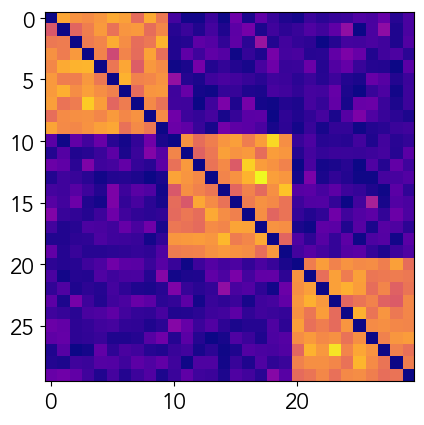

In [18]:
plt.imshow(Wij_rest)

In [83]:
wc_block = WCTaskSim(Wij_task_dict,
                     Wij_rest,
                     D,
                     rest_before=True,
                     first_duration=8,
                     onset_time_list=[600],
                     duration_list=8,
                     task_name_list=["task_A"],
                     append_outputs=True,
                     last_duration=0)

In [84]:
rho, var_rho = 0.34, 0.0024
k, var_k = 0.65, 0.015
gamma, var_gamma = 0.41, 0.002
alpha, var_alpha = 0.32, 0.0015
tau, var_tau = 0.98, 0.0568
Rho = np.random.normal(rho, np.sqrt(var_rho), size=(num_regions,))
Gamma = np.random.normal(gamma, np.sqrt(var_gamma), size=(num_regions,))
K = np.random.normal(k, np.sqrt(var_k), size=(num_regions,))
Tau = np.random.normal(tau, np.sqrt(var_tau), size=(num_regions,))
Alpha = np.random.normal(alpha, np.sqrt(var_alpha), size=(num_regions,))
bw_params_indiv = {"alpha": Alpha,
            "rho": Rho,
            "tau":Tau,
            "gamma":Gamma,
            "k":K,
            }

bw_params_fix = {"alpha": 0.32,
            "rho":0.34,
            "tau":0.98,
            "gamma":0.41,
            "k":0.65,
            }

In [85]:
wc_block.generate_full_series(bold_chunkwise=True,
                              TR=2,
                              activity=False,
                              a_s_rate=0.02,
                              normalize_max=2,
                              output_activation='syn_act',
                              fix_bold=True,
                             **bw_params_fix)

In [86]:
wc_block.BOLD.shape

(30, 308)

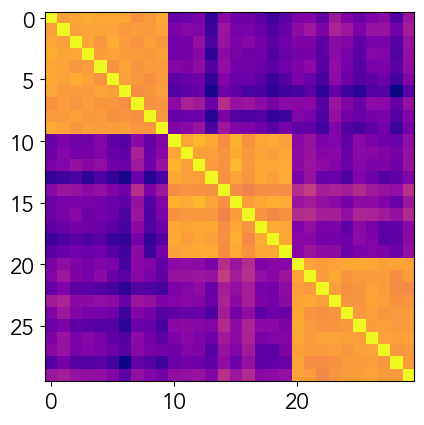

In [87]:
plt.imshow(np.corrcoef(wc_block.BOLD[:,5:-5]))


In [88]:
np.save('../results/wc_indBW30_5m.npy', wc_block.BOLD[:, 5:-5])

In [89]:
series = np.load('../results/wc_indBW30_5m.npy')

In [92]:
series.shape

(30, 298)

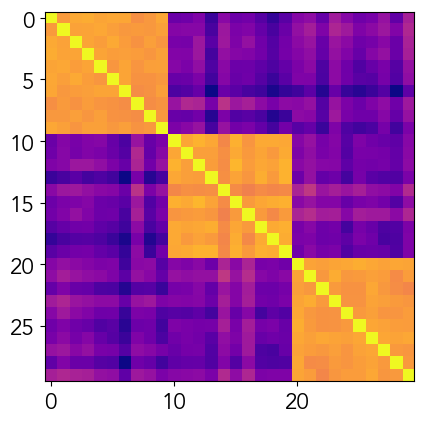

In [91]:
plt.imshow(np.corrcoef(series[:,20:-20]))

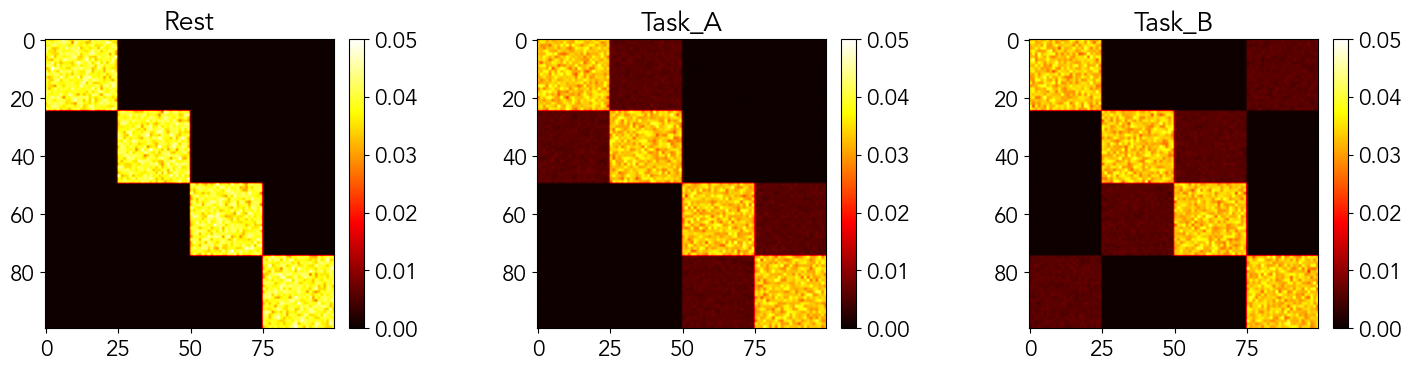

In [98]:
N_ROIs = 100 # number of brain regions
SIGMA = 0.1 # standard deviation of Gaussian distribution for synaptic weights generation
NORM_TYPE = "cols" # normalize by columns (all inputs to each region summed to one)
NUM_MODULES = 4 # number of functional modules 
GEN_TYPE = 'simple_prod' # generation type, simple_prod or equal_var
mat_path = '../data/01_BLOCK_[2s_TR]_[20s_DUR]_[10_BLOCKS].mat'
#generate matrices using weighting factors, which we specified in "task_matrices" and "rest_matrices" sturctures of the task design .mat file
C_rest, C_task_dict = generate_sw_matrices_from_mat(mat_path, N_ROIs, num_modules=NUM_MODULES,
                                sigma=SIGMA, norm_type=NORM_TYPE, gen_type = GEN_TYPE)
C_task_list = list(C_task_dict.values())
C_list = [C_rest]+C_task_list
title_list =['Rest']+ list(C_task_dict.keys())
fig, axs = plt.subplots(1, 3, figsize = (15,4))
D = np.ones((N_ROIs, N_ROIs)) * 250
np.fill_diagonal(D, 0)
#list of possible colormaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
for i in [0,1,2]:
    im = axs[i].imshow(C_list[i], cmap='hot', vmin = 0, vmax=0.05); axs[i].set_title(title_list[i]);
    fig.colorbar(im, ax = axs[i], fraction=0.046, pad=0.04);
fig.tight_layout()

In [97]:
Wij_rest = C_task_dict['Task_B']

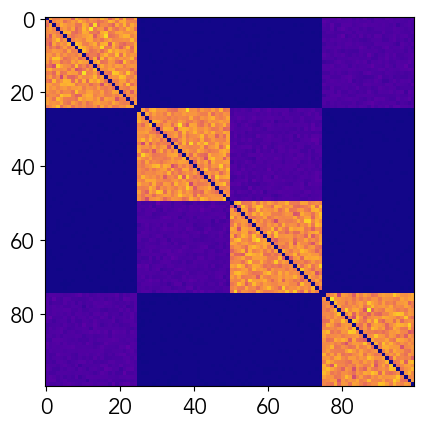

In [104]:
plt.imshow(Wij_rest)
wc_block = WCTaskSim(C_task_dict,
                     Wij_rest,
                     D,
                     rest_before=True,
                     first_duration=8,
                     onset_time_list=[600],
                     duration_list=8,
                     task_name_list=["Task_A"],
                     append_outputs=True,
                     last_duration=0)

In [105]:
wc_block.generate_full_series(bold_chunkwise=True,
                              TR=2,
                              activity=False,
                              a_s_rate=0.02,
                              normalize_max=2,
                              output_activation='syn_act',
                              fix_bold=True,
                             **bw_params_fix)

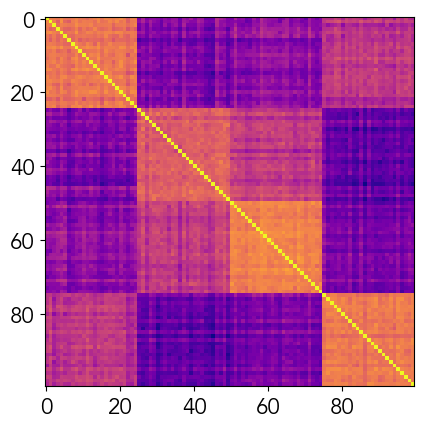

In [106]:
plt.imshow(np.corrcoef(wc_block.BOLD[:,5:-5]))


In [107]:
np.save('../results/wc_indBW100_5m.npy', wc_block.BOLD[:, 5:-5])
